## Notebook z zadaniami
<br>
W tym notebooku przedstawiamy 5 utrwalających techniki które znajdują są w użyte w modelu NeRF.

* [Zadanie 1 [Oceniane]](#Zadanie-1-Oceniane)<br>
* [Zadanie 2](#Zadanie-2)<br>
* [Zadanie 3](#Zadanie-3)<br>
* [Zadanie 4 [Oceniane]](#Zadanie-4-Oceniane)<br>
* [Zadanie 5](#Zadanie-5)<br>


## Zadanie 1 [Oceniane]
Napisz implementacje funkcji loss bazującej na notebooku NeRF (MSE), a następnie porównaj loss dla zdjęcia org z zdjęciami b1 ... b5. Te zdjęcia to rozmazana zblurowana elza z obrazka org.jpg. Opisz wyniki.

Czy można spróbować użyć innej metody loss? Uzasadnij swoją odpowiedź i uzupełnij ją przykładem.

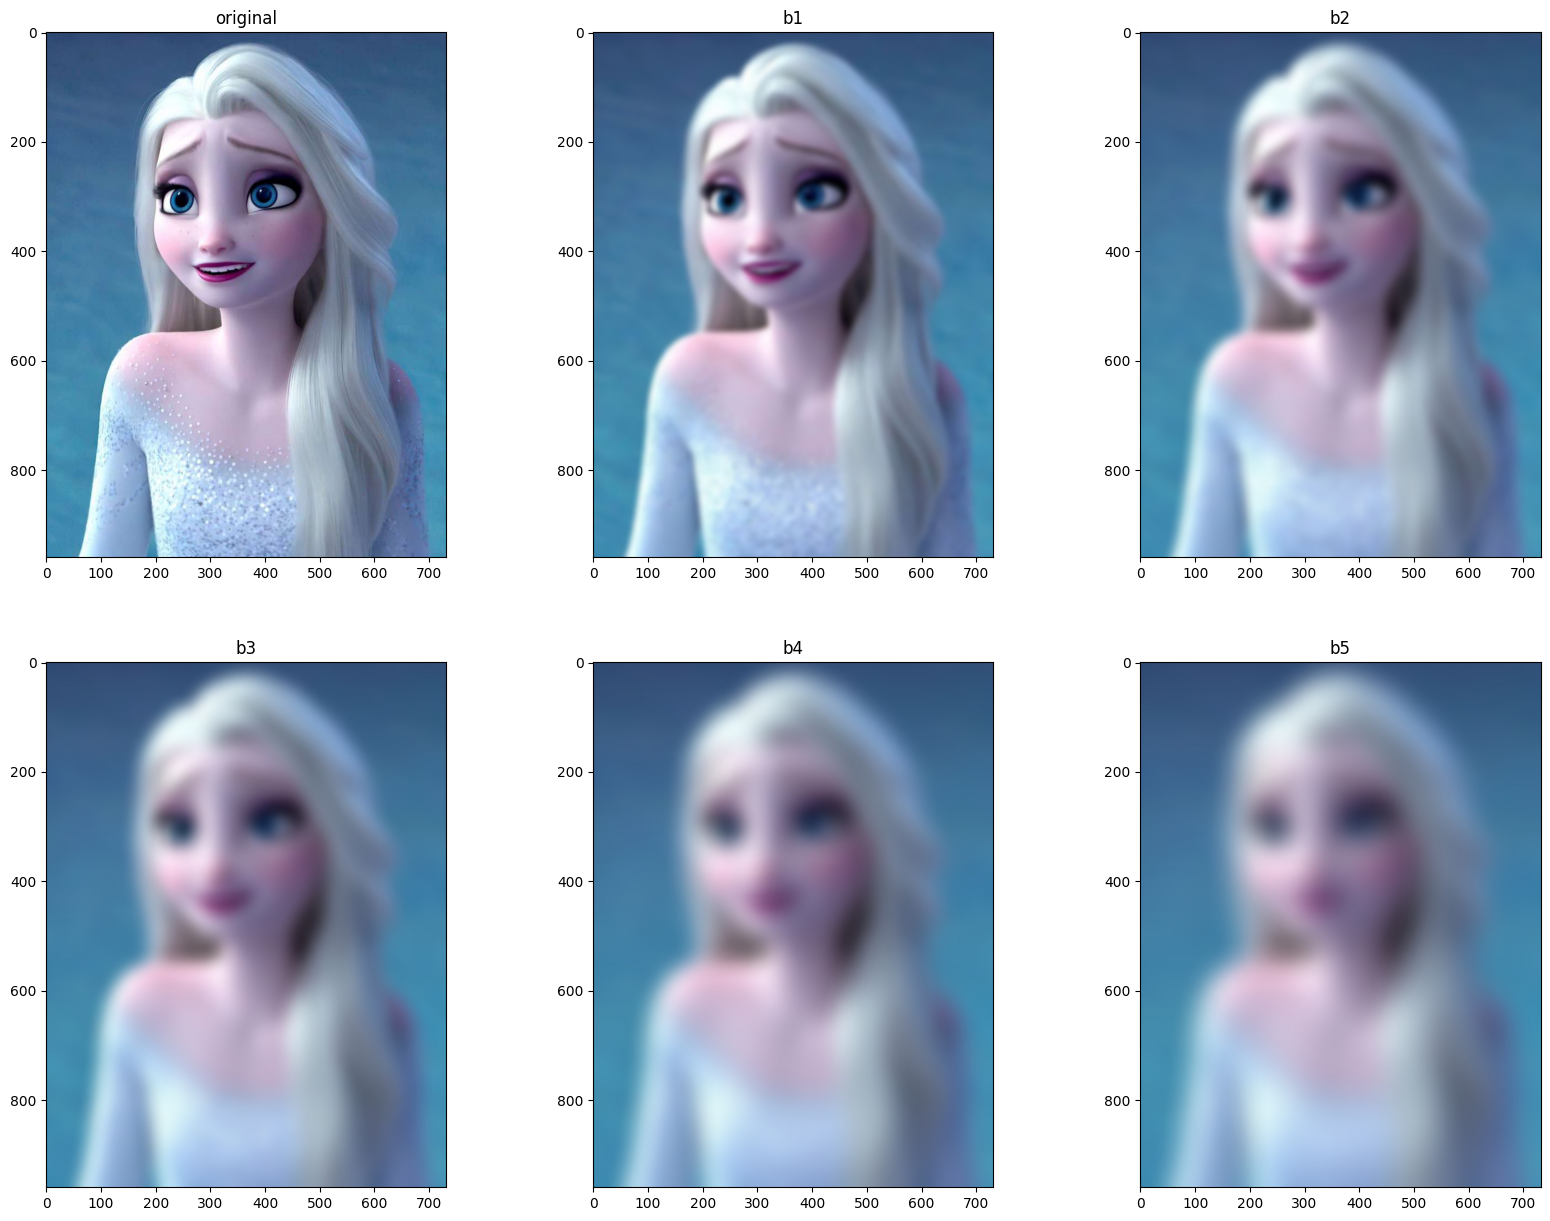

In [95]:
#kodzik pokazujacy zdjęcia
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch

def load_image(path):
    image = Image.open(path)
    transform = transforms.PILToTensor()
    return transform(image) / 255

n_images = 6 
cols = 3 
rows = n_images // cols 

plt.figure(figsize=(20, 15))  

elza = load_image('elza/org.jpg')
plt.subplot(rows, cols, 1)
plt.title('original')
plt.imshow(elza.permute(1, 2, 0).numpy())

for i in range(2, n_images + 1):
    elza = load_image(f'elza/b{i-1}.jpg') 
    plt.subplot(rows, cols, i)
    plt.title(f'b{i-1}')
    plt.imshow(elza.permute(1, 2, 0).numpy())

plt.show()

In [ ]:
import matplotlib.pyplot as pyplot

def image_loss(input, target):
     # początek kodu niewidocznego dla studentów
    
     # koniec kodu niewidocznego dla studentów


def calculate_losses(org_tensor, tensors):
     # początek kodu niewidocznego dla studentów

     # koniec kodu niewidocznego dla studentów


Text(0, 0.5, 'Losses')

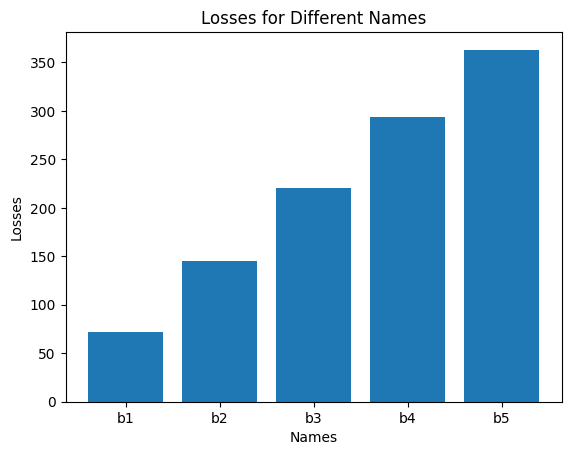

In [ ]:
org_tensor = load_image('elza/org.jpg')
names = ['b' + str(i) for i in range(1, 6)]
tensors = [load_image('elza/' + name + '.jpg') for name in names]
losses = calculate_losses(org_tensor, tensors)

fig, ax = pyplot.subplots()
ax.bar(names, losses)
ax.set_title('Losses for Different Names')
ax.set_xlabel('Names')
ax.set_ylabel('Losses')

## Zadanie 2
Oto proste modele których zadaniem bedzie klasyfikacja czy punkt znajduje sie wewnątrz koła jednostkowego czy może poza nim.

Model RegularNet nie wykonuje przekształcenia na danych wejściowych
Model FourierNet dokonuje Fourier Feature

Poeksperymentuj z różnymi rodzajami transformacji ( parametr L oraz mnożenie przez macierz B).
Co się stanie gdy parametr L będzie mały?
Co się stanie gdy parametr L będzie duży?
Co się stanie jeżeli nie bedziemy mnożyć przez B?
Czy skalowanie macierzy B może poprawić wyniki sieci?

Wyciągnij wnioski i odpowiedz na powyższe pytania.
Odpowiedzi uzasadnij odpowiednimy wykresami.


<---- Miejsce na odpowiedź ---->

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import optim

L = 10  
N = 1000 
E = 500

def generate_data(size):
    data = np.random.uniform(-2., 2., (size, 2))
    labels = np.zeros(size)
    for i in range(size):
        if np.linalg.norm(data[i]) < 1.0:
            labels[i] = 1
    return torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

data_train, data_label_train = generate_data(N)
data_test, data_label_test = generate_data(N // 6)

criterion = torch.nn.BCELoss()

In [ ]:
class RegularNet(nn.Module):
    def __init__(self):
        super(RegularNet, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    

class FourierNet(nn.Module):
    def __init__(self, L):
        super(FourierNet, self).__init__()
        self.L = L
        self.B = torch.randn(2*L) 
        self.fc1 = nn.Linear(4*L, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        stacked = []
        for i in range(self.L):
            stacked.append(torch.sin(2. * np.pi * x * self.B[2*i]))  
            stacked.append(torch.cos(2. * np.pi * x * self.B[2*i + 1])) 
        x = torch.cat(stacked, dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    
def train_loop(epochs, model, criterion, train_data, transform_func = None):
    if transform_func:
        train_data = transform_func(train_data)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        outputs = model(train_data)
        loss = criterion(outputs.squeeze(), data_label_train)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        optimizer.zero_grad()
        
        with torch.no_grad():
            outputs_test = model(data_test)
            loss_test = criterion(outputs_test.squeeze(), data_label_test).item()
            test_loss.append(loss_test)
    return train_loss, test_loss

In [ ]:
reg_model = RegularNet()
train_loss_regular, test_loss_regular = train_loop(E, reg_model, criterion, data_train)

In [ ]:
fourier_model = FourierNet(L)
train_loss_fourier, test_loss_fourier = train_loop(E, fourier_model, criterion, data_train)

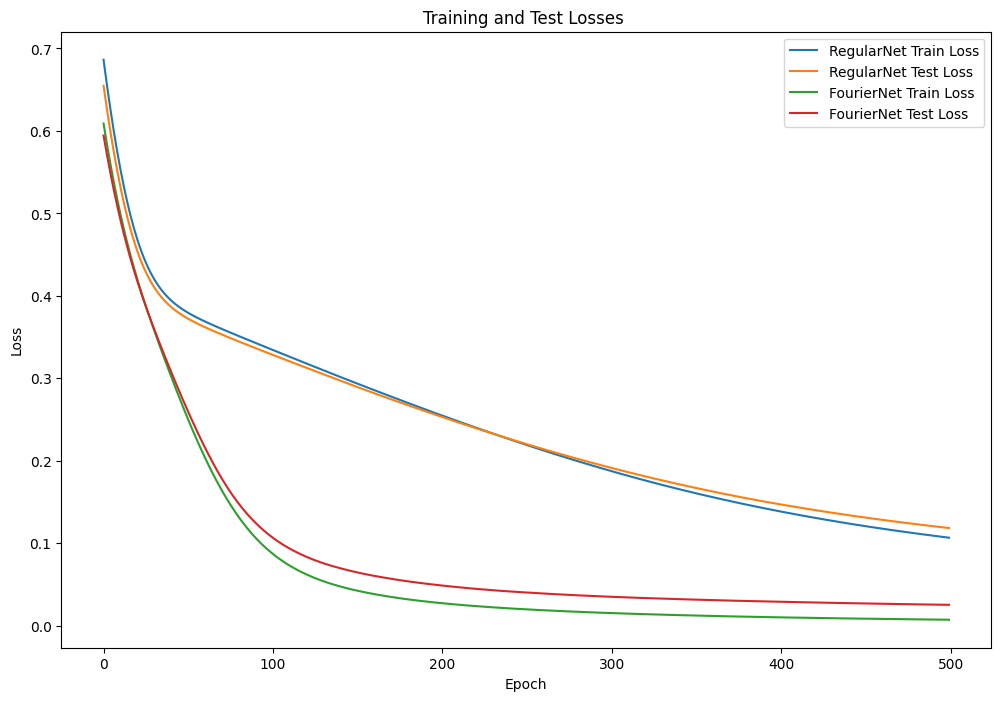

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(train_loss_regular, label='RegularNet Train Loss')
plt.plot(test_loss_regular, label='RegularNet Test Loss')

plt.plot(train_loss_fourier, label='FourierNet Train Loss')
plt.plot(test_loss_fourier, label='FourierNet Test Loss')

plt.title('Training and Test Losses ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Zadanie 3
Napisz i wytrenuj model którego zadaniem bedzie zapamiętanie zdjęcia. Jako loss używaj funkcji loss z pierwszego zadania.
Zdjęciem które bedzie należy zapamietać jest org_smaller.jpg

Dla modelu bez FF proponuje następującą strukture:

1.
    * Conv2d( 3, 256, kernel_size=1, padding=0)
    * ReLU()
    * BatchNorm2d(256)
2.
    * Conv2d(256, 256, kernel_size=1, padding=0)
    * ReLU()
    * BatchNorm2d(256)
3.
    * Conv2d(256, 256, kernel_size=1, padding=0)
    * ReLU()
    * BatchNorm2d(256)
4. Conv2d(256, 3, kernel_size=1, padding=0)
5. Sigmoid()

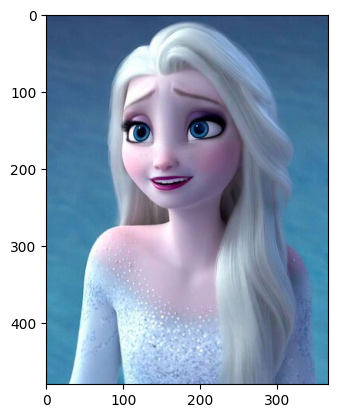

target:  torch.Size([1, 3, 480, 366])


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(path):
    image = Image.open(path)
    transform = transforms.PILToTensor()
    return transform(image) / 255

elza = load_image('elza/org_smaller.jpg') 
plt.imshow(elza.permute(1, 2, 0).numpy())
plt.show()

target = elza.unsqueeze(0).to(device) 

print("target: ", target.shape)

coordsw = np.linspace(0, 1, target.shape[2], endpoint=False)
coordsh = np.linspace(0, 1, target.shape[3], endpoint=False)
xy_grid = np.stack(np.meshgrid(coordsh, coordsw), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

Epoch 0, loss = 0.074


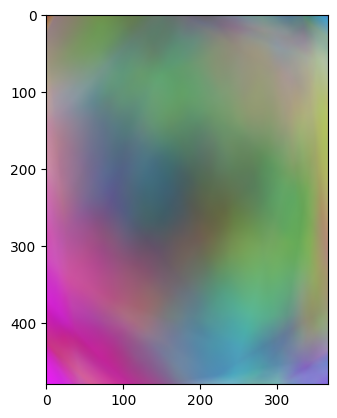

Epoch 100, loss = 0.018


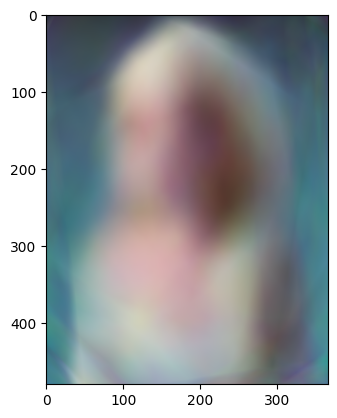

Epoch 200, loss = 0.012


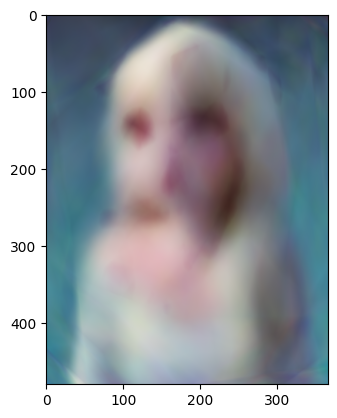

Epoch 300, loss = 0.008


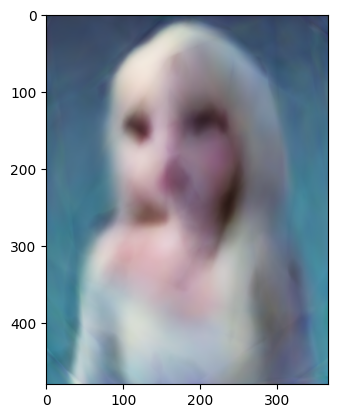

Epoch 400, loss = 0.005


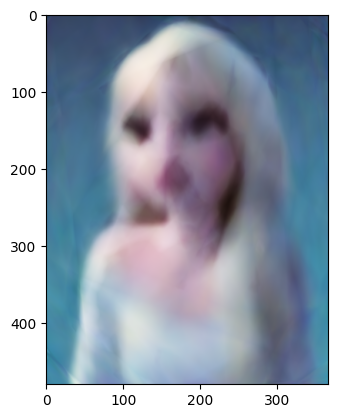

In [ ]:
import torch.nn as nn

class ImageRemember(nn.Module):
    def __init__(self):
          super(ImageRemember, self).__init__()
          # początek kodu niewidocznego dla studentów
    

    
          # koniec kodu niewidocznego dla studentów

    def forward(self, x):
          # początek kodu niewidocznego dla studentów



          # koniec kodu niewidocznego dla studentów
          return x

imageModel = ImageRemember().to(device)

optimizer = torch.optim.Adam(list(imageModel.parameters()), lr=1e-4)

for epoch in range(401):
      # Uwaga: generated = output z modelu
      # początek kodu niewidocznego dla studentów



      # koniec kodu niewidocznego dla studentów
      if epoch % 100 == 0:
            print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
            plt.imshow(generated[0].permute(1, 2, 0).detach().cpu().numpy())
            plt.show()

## Zadanie 4 [Oceniane]
Napisz funkcje która będzie robić Fourier Feature dla wejścia z poprzedniego zadania. <br>
Implementacja polega mniej więcej na tym, że dla piksela należy zastosować funkcje:
$$ \gamma(p) = \left[ \sin(2^0 \pi p B), \sin(2^1 \pi p B), \dots, \sin(2^{L-1} \pi p B), \cos(2^0 \pi p B), \cos(2^1 \pi p B), \dots, \cos(2^{L-1} \pi p B) \right] $$
gdzie:
* $p$ - współrzędne piksela (x, y)
* $B$ - macierz o wymiarach $[2, L]$ wylosowana z rozkładu normalnego
* $L$ - parametr funkcji

Dla tensora wejściowego o wymiarach [B, 2, H, W] funkcja powinna zwrócić tensor o wymiarach [B, 2 * L, H, W] <br>

Wskazówka: warto zamienić wymiary z [B, 2, H, W] na [B * H * W, 2] przed mnożeniem przez macierz $B$, która ma wymiar [2, L]

**Uwaga**: do wylosowania macierzy $B$ należy użyć funkcji [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html)


In [31]:
import numpy as np
import torch

def gaussian_fourier_feature_transform(x, mapping_size=256, scale=10):
    """
    Args:
        x: tensor of shape [B, 2, H, W]
        mapping_size: (L in the lecture notes) number of random fourier features
        scale: scale of the gaussian distribution
    Returns:
        Tensor of shape [B, 2 * L, H, W]
    """
    # początek kodu niewidocznego dla studentów



    # koniec kodu niewidocznego dla studentów

In [32]:
x = torch.tensor([[[[1., 2.], [3., 4.]]]])
mapping_size = 2
scale = 1

torch.manual_seed(0)
transformed = gaussian_fourier_feature_transform(x, mapping_size, scale)

expected = torch.tensor(
    [[[[-0.2547,  0.4927],
       [-0.6981,  0.8575]],
      [[-0.9630,  0.5191],
       [ 0.6832, -0.8873]],
      [[-0.9670,  0.8702],
       [-0.7160,  0.5145]],
      [[-0.2695, -0.8547],
       [ 0.7302,  0.4612]]]])

print("Output:\n", transformed)
print(torch.allclose(transformed, expected, atol=1e-4))


Output:
 tensor([[[[-0.2547,  0.4927],
          [-0.6981,  0.8575]],

         [[-0.9630,  0.5191],
          [ 0.6832, -0.8873]],

         [[-0.9670,  0.8702],
          [-0.7160,  0.5145]],

         [[-0.2695, -0.8547],
          [ 0.7302,  0.4612]]]])
True


## Zadanie 5
Napisz i wytrenuj model który bedzie miał podobną strukture jak ten z zadania 3, z tą różnicą że wejścia zostaną przetworzone używając Fourier Feature. Jako loss używaj funkcji loss z pierwszego zadania.


Model o nastepującej strukturze będzie w zupełności wystarczający: 

1. 
    * Conv2d( 256,256,kernel_size=1,padding=0)
    * ReLU()
    * BatchNorm2d(256)
2.
    * Conv2d(256,256,kernel_size=1,padding=0)
    * ReLU()
    * BatchNorm2d(256)
3.
    * Conv2d(256,256,kernel_size=1,padding=0)
    * ReLU()
    * BatchNorm2d(256)

4. Conv2d(256,3,kernel_size=1,padding=0)
5. Sigmoid()

Spróbuj znaleźć najlepsze parametry dla których sieć najlepiej zapamiętuje zdjęcie.
Opisz co sie dzieje jeżeli L będzie za małe lub leżeli L będzie za duże.
Jak jego wartość wpływa na uczenie sieci

Epoch 0, loss = 0.069


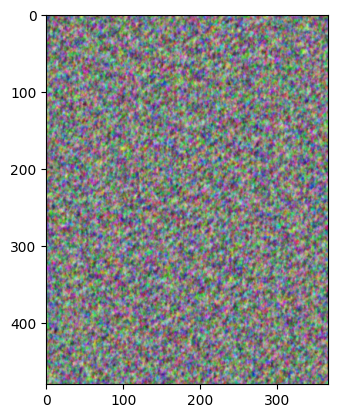

Epoch 100, loss = 0.028


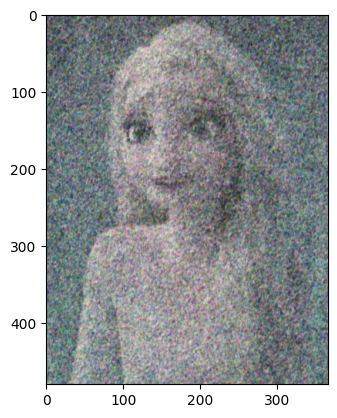

Epoch 200, loss = 0.012


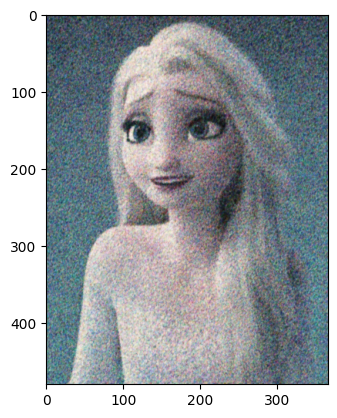

Epoch 300, loss = 0.007


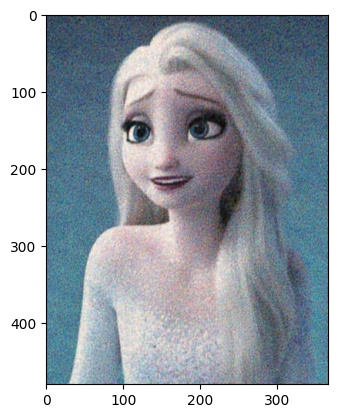

Epoch 400, loss = 0.004


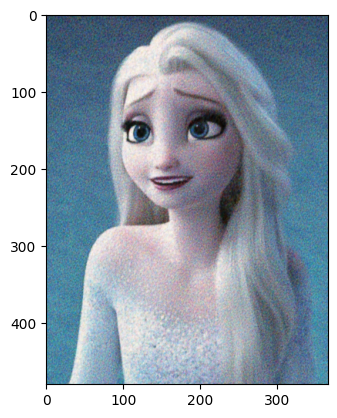

In [12]:
K_SIZE = 256

class FurierImageRemember(nn.Module):
    def __init__(self):
        super(FurierImageRemember, self).__init__()
         # początek kodu niewidocznego dla studentów
        


         # koniec kodu niewidocznego dla studentów

    def forward(self, x):
         # początek kodu niewidocznego dla studentów



         # koniec kodu niewidocznego dla studentów
        return x

fourier = FurierImageRemember().to(device)

x = gaussian_fourier_feature_transform(xy_grid,2, K_SIZE//2, 30)

optimizer = torch.optim.Adam(list(fourier.parameters()), lr=1e-4)

for epoch in range(401):
     # Uwaga: generated = output z modelu
     # początek kodu niewidocznego dla studentów



     # koniec kodu niewidocznego dla studentów

     if epoch % 100 == 0:
          print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
          plt.imshow(generated[0].permute(1, 2, 0).detach().cpu().numpy())
          plt.show()


## Podsumowanie
Mamy nadzieje że te rozwiązanie tych zadań poszerzy horyzonty tego co może być osiągnięte za pomocą sieci neuronowych podczas analizy, interpretacji i manipulacji na zdjęciach. Te ćwiczenia dobrze pokazują że czasem można drastycznie poprawić wyniki sieci jedynie traktując dane wejściowe za pomocą Fourier Feature.